In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import seaborn as sns
import yfinance as yf
import math
import warnings

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = yf.download("AAPL", start="2013-01-01", end="2024-01-31")

[*********************100%%**********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.747717,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.536329,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.075708,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,15.981149,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.024162,458707200
...,...,...,...,...,...,...
2024-01-24,195.419998,196.380005,194.339996,194.500000,194.252121,53631300
2024-01-25,195.220001,196.270004,193.110001,194.169998,193.922546,54822100
2024-01-26,194.270004,194.759995,191.940002,192.419998,192.174774,44594000


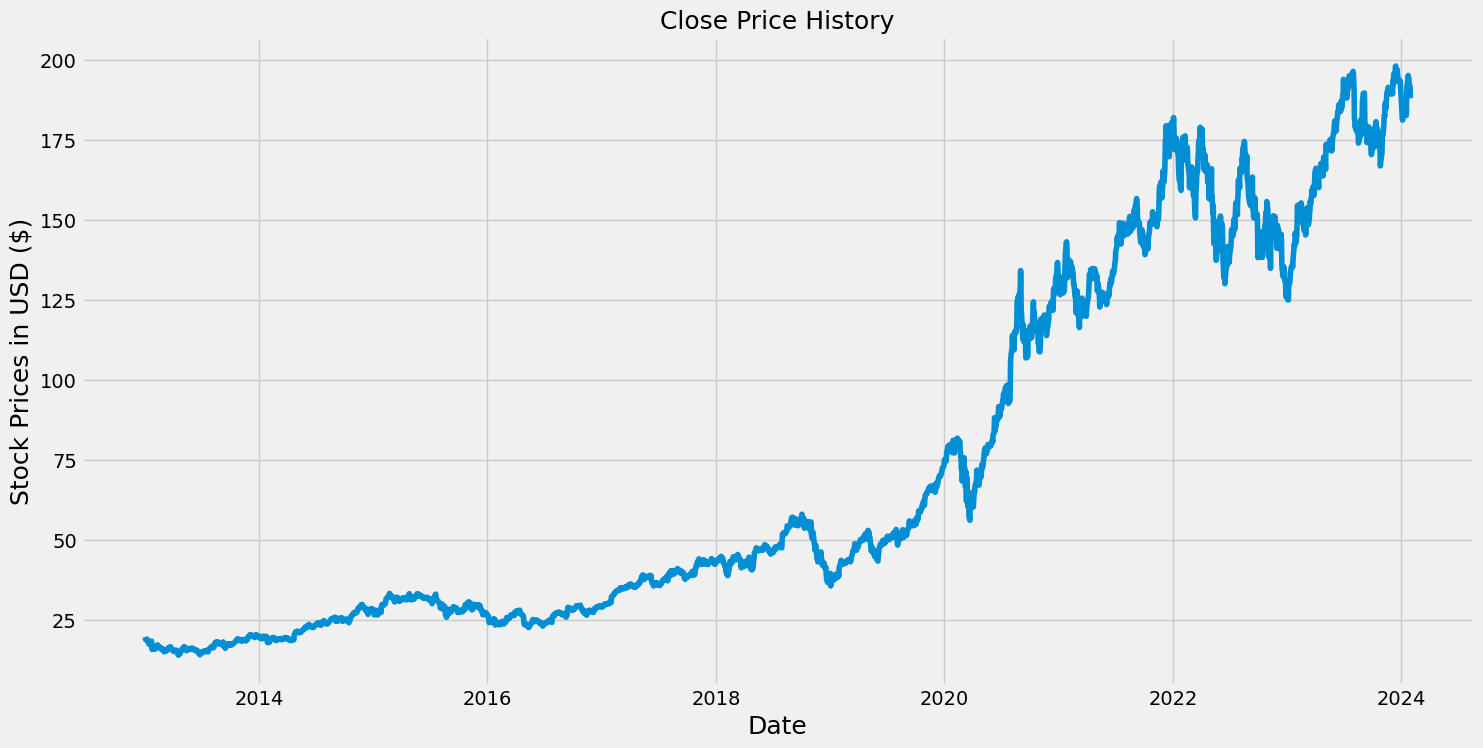

In [4]:
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=18)
plt.plot(df["Close"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Stock Prices in USD ($)", fontsize=18)
plt.show()

In [5]:
data = df.filter(['Close'])

training_data_len = math.ceil(len(data) * 0.75)
training_data_len

2091

In [6]:
data

,Close
Date,
2013-01-02,19.608213
2013-01-03,19.360714
2013-01-04,18.821428
2013-01-07,18.710714
2013-01-08,18.761070
...,...
2024-01-24,194.500000
2024-01-25,194.169998
2024-01-26,192.419998


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.0307376 ],
       [0.02939368],
       [0.02646537],
       ...,
       [0.96910336],
       [0.96535666],
       [0.94531999]])

In [8]:
import joblib

joblib.dump(scaler, 'scaler.pkl')

scaler = joblib.load('scaler.pkl')

In [9]:
train_data = scaled_data[:training_data_len]

xtrain = []
ytrain = []

for i in range(60, len(train_data)):
    xtrain.append(train_data[i-60:i, 0])
    ytrain.append(train_data[i, 0])
    if i <= 60:
        print("xtrain",xtrain)
        print("ytrain",ytrain)
        print()

xtrain [array([0.0307376 , 0.02939368, 0.02646537, 0.02586419, 0.02613762,
       0.02454548, 0.02578857, 0.02516605, 0.02156869, 0.0184988 ,
       0.02241033, 0.02174903, 0.02122931, 0.02215435, 0.02394624,
       0.01162987, 0.00957035, 0.01149994, 0.01313669, 0.01285743,
       0.01259757, 0.01223492, 0.01004354, 0.0130533 , 0.01295828,
       0.01506628, 0.01637723, 0.01733717, 0.01500422, 0.01483162,
       0.01475017, 0.01350322, 0.01347024, 0.01130989, 0.01076882,
       0.01168998, 0.01013662, 0.01133316, 0.01047987, 0.00986512,
       0.00774549, 0.00572476, 0.00787542, 0.00681269, 0.00776682,
       0.0079879 , 0.00918055, 0.00734987, 0.00733436, 0.00813917,
       0.0103034 , 0.01264218, 0.01240365, 0.01193627, 0.01206232,
       0.01384259, 0.01416645, 0.01369326, 0.01193627, 0.01010947])]
ytrain [0.007442960346339816]



In [10]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)

In [11]:
xtrain.shape

(2031, 60)

In [12]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtrain.shape

(2031, 60, 1)

In [13]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(xtrain.shape[1], 1)))
model.add(LSTM(75, return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.fit(xtrain, ytrain, batch_size=1, epochs=1)


2031/2031 [==============================] - 67s 30ms/step - loss: 9.4769e-04


In [16]:
test_data = scaled_data[training_data_len - 60:, :]
xtest = []
ytest = data.values[training_data_len:, :]

for i in range(60, len(test_data)):
    xtest.append(test_data[i-60:i, 0])

In [17]:
xtest = np.array(xtest)

In [18]:
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

In [19]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 1s 20ms/step


In [20]:
rmse = np.sqrt(np.mean(predictions-ytest)**2)
rmse

2.3484900651053344

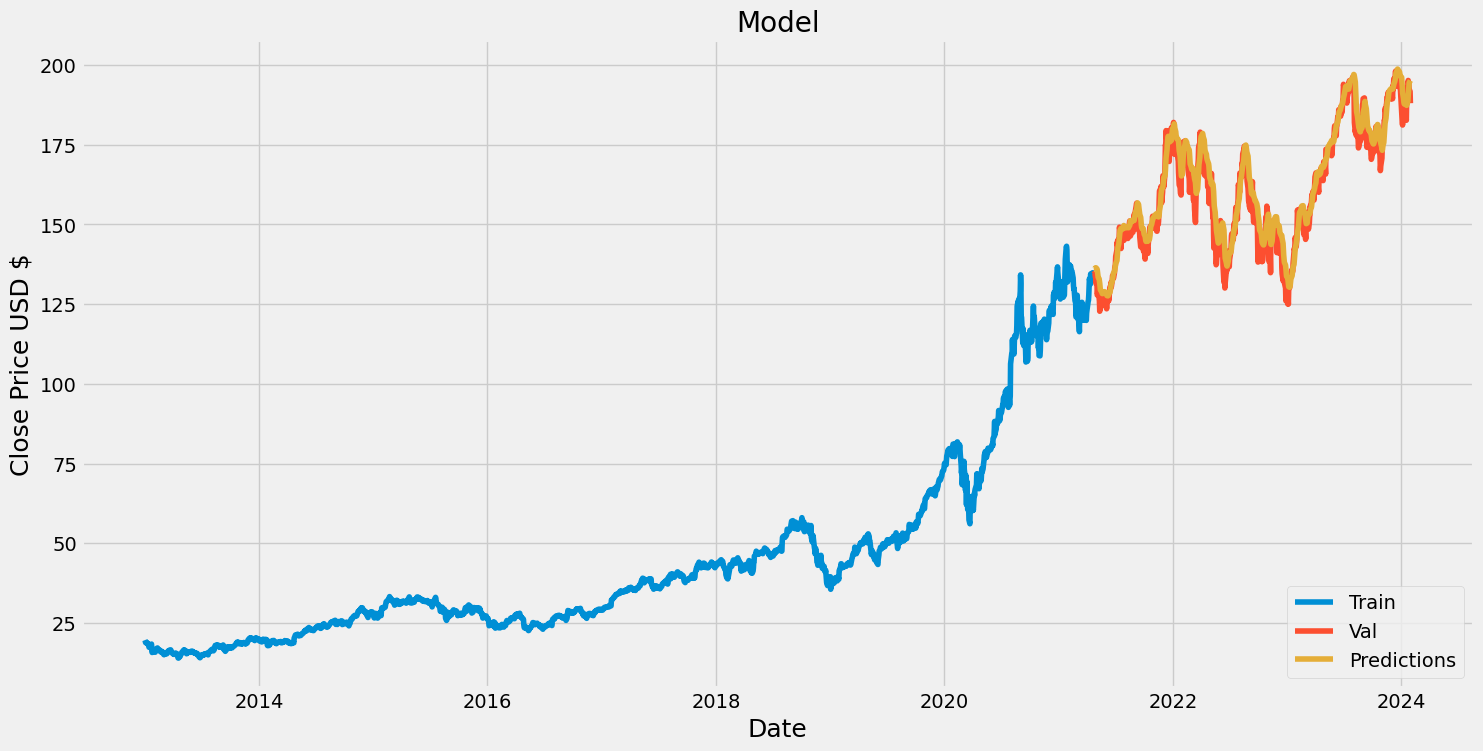

In [21]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD $", fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
valid

,Close,Predictions
Date,,
2021-04-23,134.320007,135.963135
2021-04-26,134.720001,136.012497
2021-04-27,134.389999,136.187622
2021-04-28,133.580002,136.361511
2021-04-29,133.479996,136.412903
...,...,...
2024-01-24,194.500000,191.889679
2024-01-25,194.169998,193.331146
2024-01-26,192.419998,194.437317


In [23]:
# Get the quote
apple_quote = yf.download(tickers= "GOOGL", start='2012-01-01', end='2024-02-09')
# Create a new Dataframe
new_df = apple_quote.filter(["Close"])
# Get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
# Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price[0][0])

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 32ms/step
147.30006


In [24]:
# Get the quote
apple_quote = yf.download(tickers= "GOOGL", start='2024-02-09', end='2024-02-10')
apple_quote["Close"].values

[*********************100%%**********************]  1 of 1 completed


array([149.])

In [24]:
model.save('stocksprediction.keras')